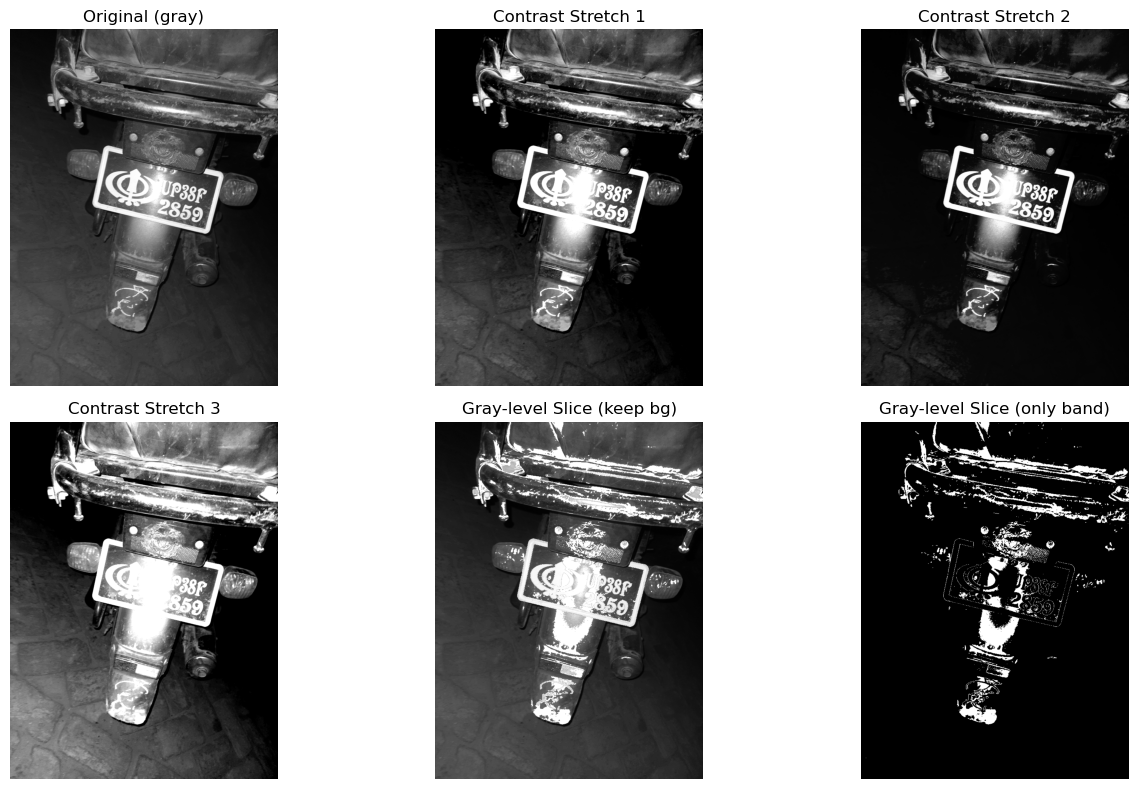

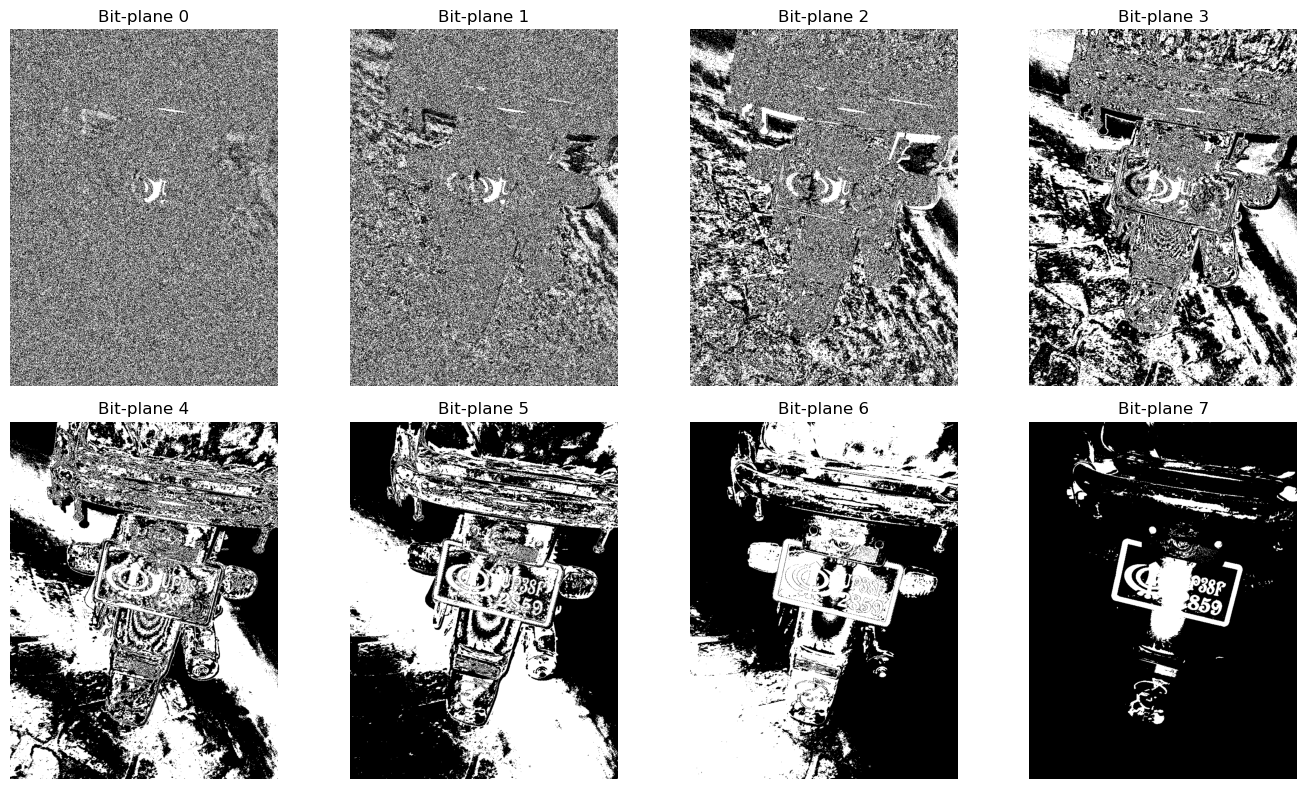

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def show_grid(titles, imgs, max_cols=4, figsize=(14,10)):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray'); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray_resized(path):
    bgr = cv2.imread(path)
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = 720.0/min(h,w); scale = min(1.0, scale)
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# 1) Contrast Stretching (piecewise-linear)
def contrast_stretch(img, r1=30, s1=0, r2=180, s2=255):
    """
    Map:
      [0, r1]   -> [0, s1]
      [r1, r2]  -> [s1, s2] (linear)
      [r2, 255] -> [s2, 255]
    """
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)

    # Segment 1
    idx1 = img <= r1
    if r1 > 0:
        out[idx1] = (s1/r1) * img[idx1]
    else:
        out[idx1] = 0

    # Segment 2
    idx2 = (img > r1) & (img <= r2)
    if r2 > r1:
        out[idx2] = s1 + ( (s2 - s1)/(r2 - r1) ) * (img[idx2] - r1)
    else:
        out[idx2] = s1

    # Segment 3
    idx3 = img > r2
    if 255 > r2:
        out[idx3] = s2 + ( (255 - s2)/(255 - r2) ) * (img[idx3] - r2)
    else:
        out[idx3] = 255

    return np.clip(out, 0, 255).astype(np.uint8)

# 2) Gray-level Slicing
def gray_level_slicing(img, a=90, b=160, with_background=True, high=255, low=0):
    """
    Highlight intensities in [a,b].
    - with_background=True: keep background as original, boost target band to 'high'
    - with_background=False: zero background, keep only highlighted band
    """
    mask = (img >= a) & (img <= b)
    if with_background:
        out = img.copy()
        out[mask] = high
    else:
        out = np.full_like(img, low)
        out[mask] = high
    return out

# 3) Bit-plane Slicing
def bit_planes(img):
    planes = []
    for k in range(8):  # 0 (LSB) .. 7 (MSB)
        plane = (img >> k) & 1
        planes.append((plane*255).astype(np.uint8))
    return planes

def main():
    gray = load_gray_resized(IMG_PATH)

    # Contrast stretching examples
    cs1 = contrast_stretch(gray, r1=40,  s1=0,   r2=180, s2=255)   # default-ish
    cs2 = contrast_stretch(gray, r1=70,  s1=10,  r2=200, s2=245)   # milder mid-range lift
    cs3 = contrast_stretch(gray, r1=30,  s1=0,   r2=130, s2=255)   # aggressive low-mid expansion

    # Gray-level slicing examples
    gls_keep = gray_level_slicing(gray, a=110, b=170, with_background=True,  high=255)
    gls_only = gray_level_slicing(gray, a=110, b=170, with_background=False, high=255, low=0)

    # Bit-plane slicing (0..7)
    planes = bit_planes(gray)  # planes[0] is LSB, planes[7] is MSB

    # Display
    show_grid(
        ["Original (gray)", "Contrast Stretch 1", "Contrast Stretch 2", "Contrast Stretch 3",
         "Gray-level Slice (keep bg)", "Gray-level Slice (only band)"],
        [gray, cs1, cs2, cs3, gls_keep, gls_only],
        max_cols=3, figsize=(14,8)
    )

    show_grid(
        [f"Bit-plane {k}" for k in range(8)],
        planes, max_cols=4, figsize=(14,8)
    )

if __name__ == "__main__":
    main()


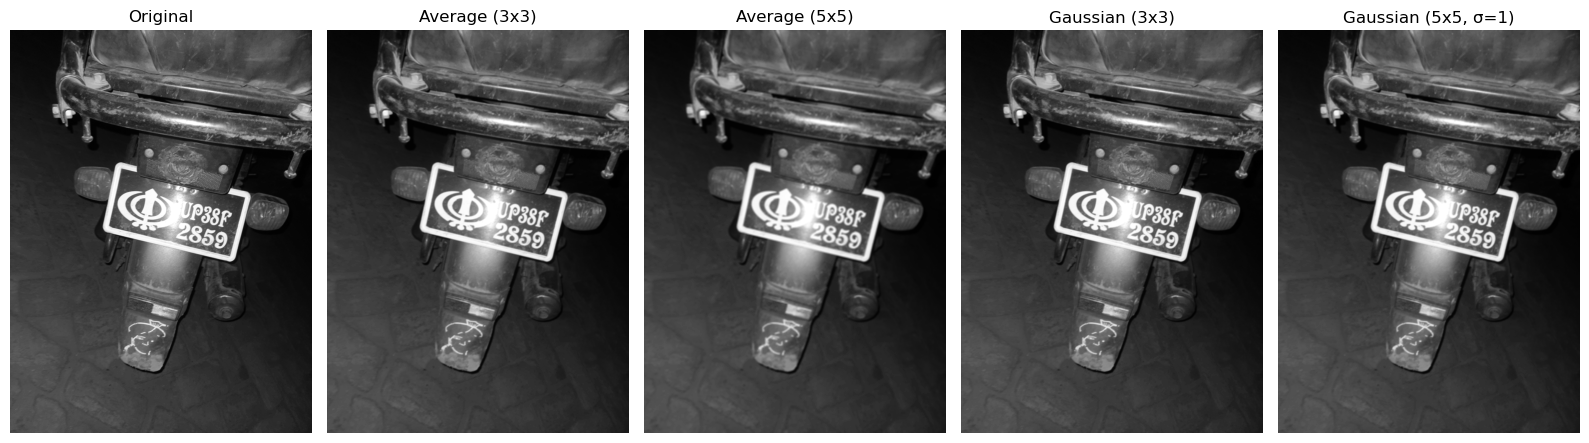

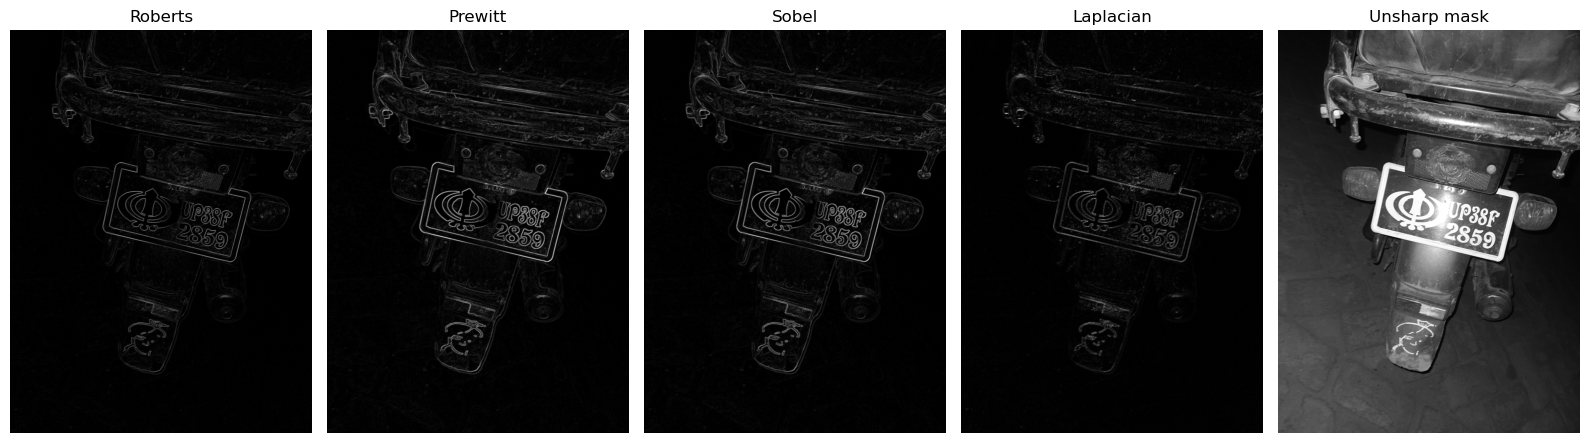

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def show_grid(titles, imgs, max_cols=4, figsize=(14,10)):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray'); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray_resized(path):
    bgr = cv2.imread(path)
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = 720.0/min(h,w); scale = min(1.0, scale)
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

def normalize8(img):
    img = np.asarray(img, dtype=np.float32)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img.astype(np.uint8)

def main():
    gray = load_gray_resized(IMG_PATH)

    # ----- Smoothing -----
    # Average (mean) filter
    avg3 = cv2.blur(gray, (3,3))
    avg5 = cv2.blur(gray, (5,5))

    # Weighted-average (Gaussian) filter
    gauss3 = cv2.GaussianBlur(gray, (3,3), sigmaX=0)
    gauss5 = cv2.GaussianBlur(gray, (5,5), sigmaX=1.0)

    # ----- Sharpening (edge extraction) -----
    # Roberts (2x2 kernels)
    kx_roberts = np.array([[1, 0],
                           [0,-1]], dtype=np.float32)
    ky_roberts = np.array([[0, 1],
                           [-1,0]], dtype=np.float32)
    rob_x = cv2.filter2D(gray, cv2.CV_32F, kx_roberts)
    rob_y = cv2.filter2D(gray, cv2.CV_32F, ky_roberts)
    roberts = normalize8(np.abs(rob_x) + np.abs(rob_y))

    # Prewitt (3x3)
    kx_prewitt = np.array([[-1,0,1],
                           [-1,0,1],
                           [-1,0,1]], dtype=np.float32)
    ky_prewitt = np.array([[-1,-1,-1],
                           [ 0,  0,  0],
                           [ 1,  1,  1]], dtype=np.float32)
    pre_x = cv2.filter2D(gray, cv2.CV_32F, kx_prewitt)
    pre_y = cv2.filter2D(gray, cv2.CV_32F, ky_prewitt)
    prewitt = normalize8(np.abs(pre_x) + np.abs(pre_y))

    # Sobel (3x3, OpenCV optimized)
    sobel_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    sobel = normalize8(np.abs(sobel_x) + np.abs(sobel_y))

    # Laplacian (second derivative)
    lap = cv2.Laplacian(gray, cv2.CV_32F, ksize=3)
    laplacian = normalize8(np.abs(lap))

    # Optional: Unsharp masking (sharpened image)
    blur = cv2.GaussianBlur(gray, (5,5), 1.0)
    unsharp = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)

    # Display
    show_grid(
        ["Original", "Average (3x3)", "Average (5x5)", "Gaussian (3x3)", "Gaussian (5x5, σ=1)"],
        [gray, avg3, avg5, gauss3, gauss5],
        max_cols=5, figsize=(16,6)
    )

    show_grid(
        ["Roberts", "Prewitt", "Sobel", "Laplacian", "Unsharp mask"],
        [roberts, prewitt, sobel, laplacian, unsharp],
        max_cols=5, figsize=(16,6)
    )

if __name__ == "__main__":
    main()


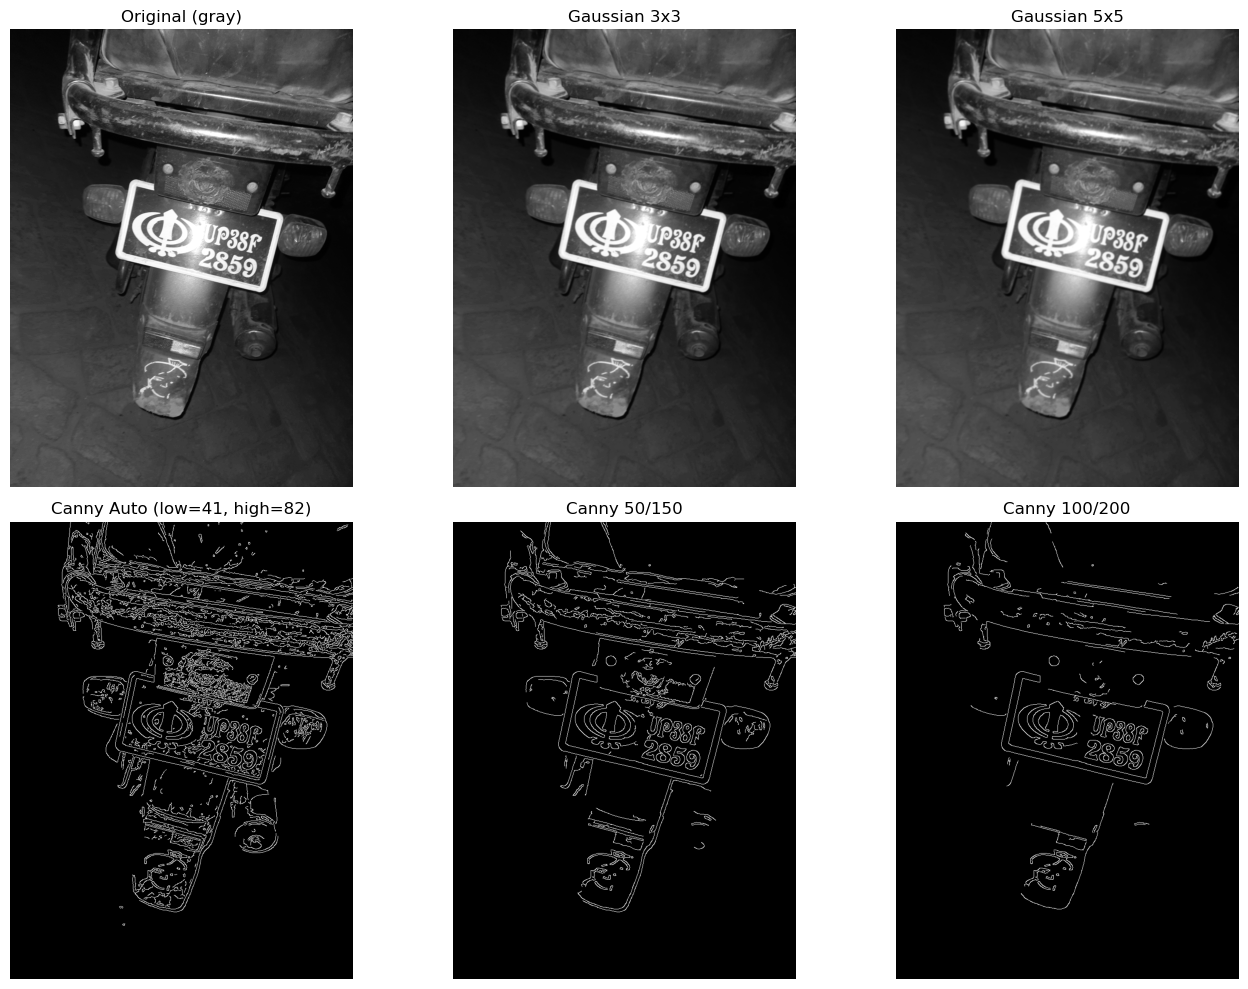

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def show_grid(titles, imgs, max_cols=3, figsize=(12,8)):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray'); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray_resized(path):
    bgr = cv2.imread(path)
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = 720.0/min(h,w); scale = min(1.0, scale)
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

def auto_canny(image, sigma=0.33):
    # Median heuristic for thresholds
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper), (lower, upper)

def main():
    gray = load_gray_resized(IMG_PATH)

    # Pre-smoothing helps suppress noise before Canny
    blur3 = cv2.GaussianBlur(gray, (3,3), 0)
    blur5 = cv2.GaussianBlur(gray, (5,5), 0)

    # Auto Canny on lightly smoothed image
    edges_auto, (lo, hi) = auto_canny(blur3, sigma=0.33)

    # Manual thresholds for comparison
    edges_soft = cv2.Canny(blur5, 50, 150)    # softer, more edges
    edges_strict = cv2.Canny(blur5, 100, 200) # stricter, fewer edges

    show_grid(
        [f"Original (gray)", "Gaussian 3x3", "Gaussian 5x5",
         f"Canny Auto (low={lo}, high={hi})", "Canny 50/150", "Canny 100/200"],
        [gray, blur3, blur5, edges_auto, edges_soft, edges_strict],
        max_cols=3, figsize=(14,10)
    )

if __name__ == "__main__":
    main()
